In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

The data we'll be working with includes a hourly/daily summary for Szeged, Hungary area, between 2006 and 2016.

Here is the link for the data on Kaggle: 
https://www.kaggle.com/datasets/budincsevity/szeged-weather

The goals of analyzing this data is to answer these questions:
- Is there a relationship between humidity and temperature?
- What about relationship between humidity and apparent temperature?
- Can we predict the apparent temperature given the humidity?

### Reading Data

In [2]:
weatherData = pd.read_csv("weatherHistory.csv", index_col="Formatted Date", parse_dates = True)

In [3]:
weatherData.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,,
2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
2006-04-01 03:00:00+02:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


### Cleaning Data

In [4]:
# Renaming columns
weatherData = weatherData.rename(columns={"Temperature (C)":"Temp", "Apparent Temperature (C)":"ApparentTemp",
                       "Wind Speed (km/h)": "WindSpeed", "Wind Bearing (degrees)": "WindBearing",
                       "Visibility (km)": "Visibility", "Pressure (millibars)":"Pressure"})

In [5]:
weatherData.dtypes

Summary           object
Precip Type       object
Temp             float64
ApparentTemp     float64
Humidity         float64
WindSpeed        float64
WindBearing      float64
Visibility       float64
Loud Cover       float64
Pressure         float64
Daily Summary     object
dtype: object

In [6]:
# Checking for null values
np.sum(weatherData.isnull())

Summary            0
Precip Type      517
Temp               0
ApparentTemp       0
Humidity           0
WindSpeed          0
WindBearing        0
Visibility         0
Loud Cover         0
Pressure           0
Daily Summary      0
dtype: int64

In [7]:
# Dropping rows containing NaN
weatherData = weatherData.dropna()

In [8]:
weatherData.describe()

,Temp,ApparentTemp,Humidity,WindSpeed,WindBearing,Visibility,Loud Cover,Pressure
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.0,95936.000000
mean,11.940976,10.862531,0.734841,10.804936,187.518773,10.362402,0.0,1003.150038
std,9.570671,10.717812,0.195724,6.920727,107.385351,4.173780,0.0,117.276976
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.604167,2.276389,0.600000,5.796000,116.000000,8.372000,0.0,1011.890000
50%,12.033333,12.033333,0.780000,9.933700,180.000000,10.046400,0.0,1016.420000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.812000,0.0,1021.050000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


From the table above we see that some columns contain zero values which is not logical. For instance, the column `Pressure` contains zero in some of its cells (the pressure of a complete vacuum). Other columns such as `Visibility`, `WindSpeed`, `Humidity` also should not contain zero. Although it is theoretically possible for these three variables to be zero, but these are unikely to accure in a city. Thus, we'll replace all zeros with the last valid observation in each column since the data that we are working with is an __hourly/daily__ summary and later observations are slightly different from previous observations.

Also, The column `Loud Cover` has no use since every cell contains zero. Thus, we'll drop this column.

In [9]:
# Dropping useless columns
weatherData = weatherData.drop(columns=["Loud Cover"])

In [10]:
# Replacing zeros with NaN
weatherData["Pressure"] = weatherData["Pressure"].replace(0, np.nan)
weatherData["Visibility"] = weatherData["Visibility"].replace(0, np.nan)
weatherData["WindSpeed"] = weatherData["WindSpeed"].replace(0, np.nan)
weatherData["Humidity"] = weatherData["Humidity"].replace(0, np.nan)

In [11]:
weatherData.fillna(method="ffill", inplace=True)

In [12]:
weatherData.describe()

,Temp,ApparentTemp,Humidity,WindSpeed,WindBearing,Visibility,Pressure
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000
mean,11.940976,10.862531,0.735013,10.858981,187.518773,10.389955,1016.804799
std,9.570671,10.717812,0.195419,6.858168,107.385351,4.150039,7.771537
min,-21.822222,-27.716667,0.120000,0.032200,0.000000,0.016100,973.780000
25%,4.604167,2.276389,0.600000,5.876500,116.000000,8.420300,1012.110000
50%,12.033333,12.033333,0.780000,9.949800,180.000000,10.046400,1016.530000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.876400,1021.140000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


Although these steps were unnecessary since we only need __temperature, apparent temperature__ and __humidity__ to work with, but it is a good and simple practice for data cleaning and analyzing, and the data that we have right now is much more logical.

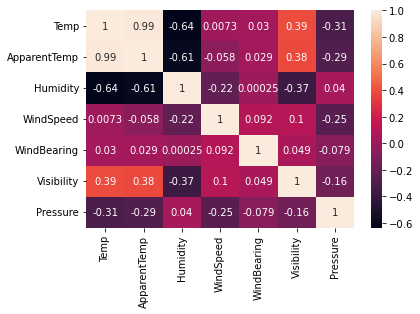

In [13]:
sns.heatmap(weatherData.corr(), annot=True)
plt.show()

The heatmap above shows a relatively larg negative correlation between temperature and humidity, and also between apparent temperature and humidity. Found the answers for the first two questions.

Let's plot both correlations with a regression.

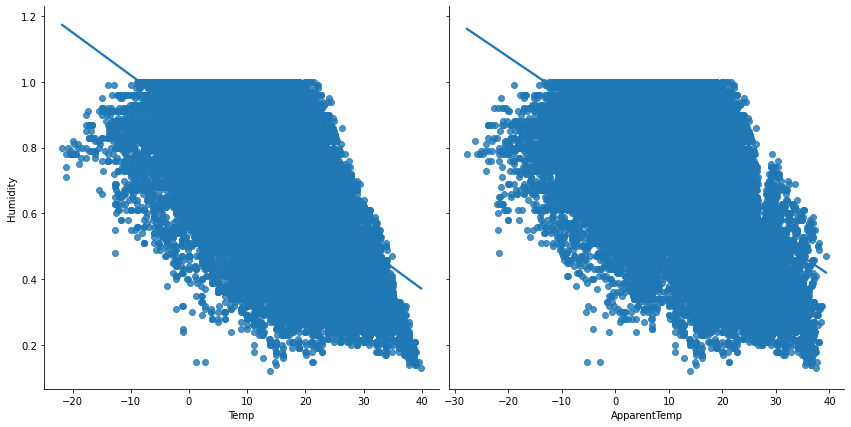

In [14]:
sns.pairplot(weatherData, x_vars=['Temp', 'ApparentTemp'], y_vars='Humidity', kind='reg', height=6)
plt.show()

### Linear Regression

In [15]:
# Let's train a Linear Regression model to predict the Apparent Temperature given the Humidity
X = weatherData["Humidity"]
y = weatherData['ApparentTemp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [16]:
model = LinearRegression()
res = model.fit(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
res.intercept_, res.coef_

(array([35.32271576]), array([[-33.31041955]]))

In [17]:
y_pred = model.predict(np.array(X_test).reshape(-1, 1))
np.sqrt(metrics.mean_squared_error(y_pred, y_test))

8.491427638080237

In [18]:
df = pd.DataFrame({})
df = pd.concat([X_test, y_test], axis=1)
df['Predicted Temp'] = y_pred.astype('int64')
df['Error'] = df['Predicted Temp'] - df['ApparentTemp']
df

,Humidity,ApparentTemp,Predicted Temp,Error
Formatted Date,,,,
2015-09-19 19:00:00+02:00,0.62,24.861111,14,-10.861111
2010-10-29 03:00:00+02:00,1.00,-1.733333,2,3.733333
2011-02-22 05:00:00+01:00,0.84,-9.666667,7,16.666667
2009-08-31 00:00:00+02:00,0.84,16.111111,7,-9.111111
2009-10-03 03:00:00+02:00,0.80,9.372222,8,-1.372222
...,...,...,...,...
2009-11-29 18:00:00+01:00,0.93,3.466667,4,0.533333
2010-05-10 15:00:00+02:00,0.67,18.838889,13,-5.838889
2006-04-11 05:00:00+02:00,0.95,10.694444,3,-7.694444
